In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, make_scorer
from scipy.cluster.hierarchy import dendrogram, linkage

pd.set_option('display.max_columns', None)

In [3]:
data = pd.read_csv("Time-Wasters on Social Media.csv")
data = data.dropna()
data = data.drop(columns = ['Video ID', 'ProductivityLoss', 'Self Control', 'CurrentActivity'])
data.head()

,UserID,Age,Gender,Location,Income,Debt,Owns Property,Profession,Demographics,Platform,Total Time Spent,Number of Sessions,Video Category,Video Length,Engagement,Importance Score,Time Spent On Video,Number of Videos Watched,Scroll Rate,Frequency,Satisfaction,Watch Reason,DeviceType,OS,Watch Time,Addiction Level,ConnectionType
0,1,56,Male,Pakistan,82812,True,True,Engineer,Rural,Instagram,80,17,Pranks,24,7867,5,26,22,87,Night,7,Procrastination,Smartphone,Android,9:00 PM,5,Mobile Data
1,2,46,Female,Mexico,27999,False,True,Artist,Urban,Instagram,228,14,Pranks,19,5944,6,25,31,46,Afternoon,5,Habit,Computer,Android,5:00 PM,3,Wi-Fi
2,3,32,Female,United States,42436,False,True,Engineer,Rural,Facebook,30,6,Vlogs,19,8674,3,9,7,88,Evening,4,Entertainment,Tablet,Android,2:00 PM,2,Mobile Data
3,4,60,Male,Barzil,62963,True,False,Waiting staff,Rural,YouTube,101,19,Vlogs,4,2477,2,6,41,93,Night,7,Habit,Smartphone,Android,9:00 PM,5,Mobile Data
4,5,25,Male,Pakistan,22096,False,True,Manager,Urban,TikTok,136,6,Gaming,19,3093,7,13,21,4,Morning,2,Boredom,Smartphone,iOS,8:00 AM,0,Mobile Data


In [14]:
# Step 1: Drop the 'UserID' column if it exists
if 'UserID' in data.columns:
    data = data.drop('UserID', axis=1)

# Step 2: Create a dictionary to store the LabelEncoder for each column
label_encoders = {}

# Step 3: Encode all non-numeric columns with unique numeric values and store encoders
for column in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le  # Save the LabelEncoder for reversing later


# Step 7: Function to reverse the encoding of a specific column
def reverse_encoding(column_name, encoded_data):
    if column_name in label_encoders:
        le = label_encoders[column_name]
        try:
            # Make sure that the function returns a scalar and not an array
            return le.inverse_transform(encoded_data)[0]  # [0] to extract the single value
        except ValueError:
            return 'Unknown'  # Handle unseen values gracefully
    else:
        return encoded_data  # If the column wasn't label-encoded, return the original data

def reverse_encoded_row(row):
    """
    Reverses the label encoding for a single row.
    """
    for column in label_encoders.keys():
        if column in row:
            try:
                # Use the reverse_encoding function to transform the value
                row[column] = reverse_encoding(column, [row[column]])  # Pass as a list and extract single value
            except:
                pass
    return row
    


In [15]:
label_encoders

{'Gender': LabelEncoder(),
 'Location': LabelEncoder(),
 'Profession': LabelEncoder(),
 'Demographics': LabelEncoder(),
 'Platform': LabelEncoder(),
 'Video Category': LabelEncoder(),
 'Frequency': LabelEncoder(),
 'Watch Reason': LabelEncoder(),
 'DeviceType': LabelEncoder(),
 'OS': LabelEncoder(),
 'Watch Time': LabelEncoder(),
 'ConnectionType': LabelEncoder()}

In [16]:
data

,Age,Gender,Location,Income,Debt,Owns Property,Profession,Demographics,Platform,Total Time Spent,Number of Sessions,Video Category,Video Length,Engagement,Importance Score,Time Spent On Video,Number of Videos Watched,Scroll Rate,Frequency,Satisfaction,Watch Reason,DeviceType,OS,Watch Time,Addiction Level,ConnectionType
0,56,1,6,82812,True,True,2,0,1,80,17,6,24,7867,5,26,22,87,3,7,3,1,0,13,5,0
1,46,0,5,27999,False,True,0,1,1,228,14,6,19,5944,6,25,31,46,0,5,2,0,0,6,3,1
2,32,0,8,42436,False,True,2,0,0,30,6,8,19,8674,3,9,7,88,1,4,1,2,0,2,2,0
3,60,1,0,62963,True,False,7,0,3,101,19,8,4,2477,2,6,41,93,3,7,2,1,0,13,5,0
4,25,1,6,22096,False,True,4,1,2,136,6,3,19,3093,7,13,21,4,2,2,0,1,3,11,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,22,1,2,74254,True,True,5,0,2,144,7,3,1,5179,6,17,17,47,0,1,3,1,3,7,0,0
996,40,0,6,27006,False,False,7,1,0,231,15,5,2,1803,4,2,17,15,3,2,0,1,1,0,0,0
997,27,1,2,94218,True,True,7,0,2,165,1,6,12,9290,3,9,28,44,3,1,3,1,3,0,0,0
998,61,1,6,85344,True,False,5,1,3,151,11,5,15,2050,5,12,30,62,3,7,3,1,1,0,5,1


## Part 1: Clustering

### 1.a Clustering with Diemnsionality Reduction (PCA) and Hyper-Paramter Tuning

In [17]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Step 1: Drop rows with NaN values
data_cleaned = data.dropna()

# Step 2: Select the features for clustering (all numerical columns)
features = data_cleaned.select_dtypes(include=['number'])

# Step 3: Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Step 4: Apply PCA to reduce the dimensionality to, say, 10 components
pca = PCA(n_components=10)
pca_features = pca.fit_transform(scaled_features)

# Let's print how much variance is explained by each principal component
print(f"Explained variance by each PCA component: {pca.explained_variance_ratio_}")


Explained variance by each PCA component: [0.09496954 0.05361117 0.05339634 0.04941918 0.04912556 0.04733689
 0.04535213 0.0447255  0.04294247 0.04231286]


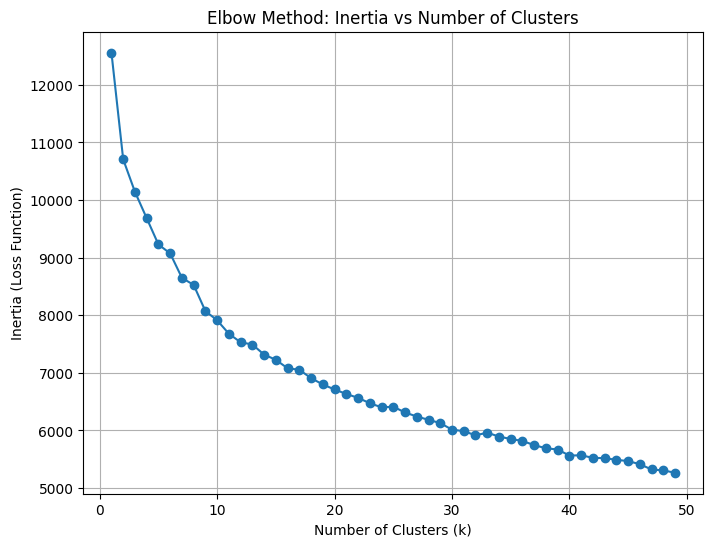

In [18]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Step 1: Define a range of cluster numbers to try
k_values = range(1, 50)  # Trying k from 1 to 50
inertia_values = []

# Step 2: Perform KMeans clustering for each k and calculate inertia (loss function)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_features)
    inertia_values.append(kmeans.inertia_) 

# Step 3: Plot the Elbow curve (Inertia vs Number of Clusters)
plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia_values, marker='o')
plt.title('Elbow Method: Inertia vs Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Loss Function)')
plt.grid(True)
plt.show()


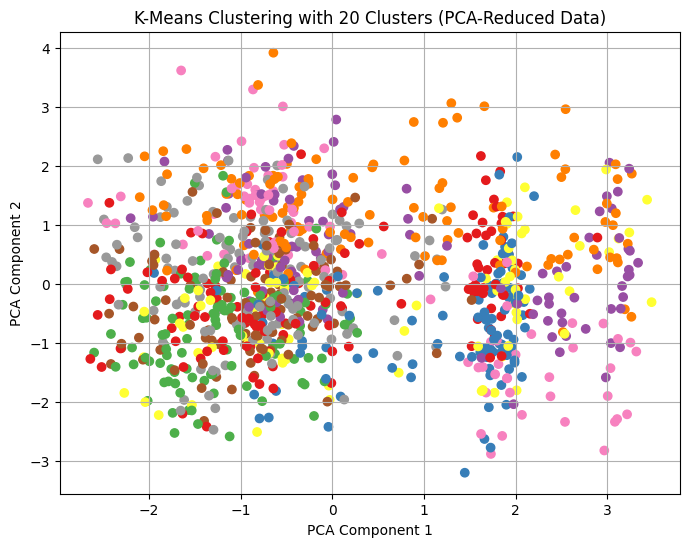

In [19]:
# K = 20 seems to be the point where exponential decrease becomes more linear

optimal_k = 20
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_final.fit(pca_features)

# Add the cluster labels to the dataframe
data_cleaned['Cluster'] = kmeans_final.labels_

# Visualize the final clusters with the first two PCA components
plt.figure(figsize=(8, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=kmeans_final.labels_, cmap='Set1')
plt.title(f'K-Means Clustering with {optimal_k} Clusters (PCA-Reduced Data)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()


In [20]:
# Calculate the mean of each feature per cluster
cluster_summary = data_cleaned.groupby('Cluster').mean()

# Print the summary statistics per cluster
print("Cluster Characteristics (mean of features per cluster):")
display(cluster_summary.sort_values(by = "Addiction Level", ascending= True))

Cluster Characteristics (mean of features per cluster):


,Age,Gender,Location,Income,Debt,Owns Property,Profession,Demographics,Platform,Total Time Spent,Number of Sessions,Video Category,Video Length,Engagement,Importance Score,Time Spent On Video,Number of Videos Watched,Scroll Rate,Frequency,Satisfaction,Watch Reason,DeviceType,OS,Watch Time,Addiction Level,ConnectionType
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,
5,41.125000,0.589286,5.464286,66212.803571,0.678571,0.625000,4.964286,0.071429,1.446429,126.375000,12.285714,4.089286,16.071429,5133.625000,6.142857,12.803571,27.839286,57.696429,2.142857,2.142857,1.214286,1.035714,1.107143,12.571429,0.303571,0.482143
18,45.514286,0.971429,5.657143,59634.457143,0.542857,0.628571,5.114286,0.828571,1.457143,153.685714,13.285714,5.542857,18.885714,5620.200000,5.342857,17.685714,18.428571,49.457143,1.742857,2.200000,1.571429,1.200000,0.742857,9.914286,0.400000,0.171429
1,34.547619,1.166667,3.380952,68737.285714,0.761905,0.500000,2.619048,0.095238,2.214286,173.142857,12.309524,6.047619,15.857143,5107.976190,4.666667,17.119048,32.595238,61.071429,1.261905,2.833333,0.619048,1.333333,0.619048,7.166667,0.904762,0.071429
6,36.948276,0.413793,3.051724,60507.017241,0.655172,0.482759,6.051724,0.051724,1.344828,146.810345,10.258621,3.500000,15.155172,4359.827586,3.793103,9.379310,34.086207,39.913793,0.913793,3.465517,1.534483,1.241379,0.931034,5.293103,1.568966,0.465517
12,50.000000,0.765957,2.659574,56550.659574,0.574468,0.659574,4.872340,0.042553,2.000000,162.553191,12.106383,3.893617,16.127660,2694.893617,3.787234,21.361702,22.255319,30.191489,0.978723,3.744681,0.765957,1.404255,1.170213,4.595745,1.829787,0.553191
15,45.055556,1.277778,6.537037,70935.944444,0.759259,0.592593,5.611111,0.203704,1.333333,120.481481,8.037037,4.185185,15.814815,5881.388889,6.129630,17.240741,12.833333,33.629630,0.888889,3.907407,1.111111,1.277778,2.111111,4.370370,1.944444,0.537037
13,37.327273,0.509091,5.400000,66610.727273,0.745455,0.600000,4.000000,0.036364,2.127273,170.654545,8.127273,2.127273,8.945455,2921.290909,5.345455,14.509091,17.527273,69.218182,0.800000,3.909091,1.345455,1.200000,0.909091,4.290909,1.963636,0.200000
17,42.051724,0.844828,4.586207,44335.465517,0.327586,0.603448,1.827586,0.155172,2.137931,159.344828,7.637931,4.637931,13.534483,4792.637931,5.827586,19.655172,32.000000,38.189655,0.827586,4.017241,1.224138,0.724138,1.896552,5.637931,2.034483,0.327586
14,38.816327,0.877551,5.142857,55532.408163,0.612245,0.448980,4.959184,0.816327,1.959184,88.612245,10.510204,2.857143,8.734694,5688.571429,6.448980,10.857143,18.040816,54.346939,0.857143,4.122449,0.795918,0.959184,1.020408,4.428571,2.122449,0.346939


### Utilizing cosine similarity to find most representative real users for each cluster

In [21]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

# Step 1: Use the PCA-reduced features for cosine similarity calculation
centroids = kmeans_final.cluster_centers_

similar_users = {}

for cluster in range(kmeans_final.n_clusters):
    # Get the indices of users in this cluster
    cluster_indices = data_cleaned[data_cleaned['Cluster'] == cluster].index
    cluster_users = pca_features[cluster_indices]  # Users in the current cluster

    # Get the centroid for the current cluster
    cluster_centroid = centroids[cluster]

    # Calculate cosine similarity between each user in the cluster and the centroid
    similarities = cosine_similarity(cluster_users, cluster_centroid.reshape(1, -1)).flatten()

    # Find the user with the highest similarity to the centroid
    most_similar_user_index = cluster_indices[np.argmax(similarities)]

    # Store the most similar user for this cluster
    similar_users[cluster] = most_similar_user_index

# Step 2: Output the most similar user for each cluster and reverse label encoding where needed
print(label_encoders)

# Create a list to hold rows of most similar users
most_similar_users = []

# Collect most similar users in a DataFrame
for cluster, user_index in similar_users.items():
    print(f"Most similar user to Cluster {cluster} centroid is at index: {user_index}")
    
    # Get the user row and reverse encodings
    user_row = data_cleaned.loc[user_index].copy()
    user_row = reverse_encoded_row(user_row)
    
    # Append the reversed row to the list
    most_similar_users.append(user_row)

# Create a DataFrame from the list of most similar users
similar_users_df = pd.DataFrame(most_similar_users)
similar_users_df = similar_users_df.sort_values(by = "Addiction Level", ascending= False)

# Display the DataFrame of most similar users
display(similar_users_df)


{'Gender': LabelEncoder(), 'Location': LabelEncoder(), 'Profession': LabelEncoder(), 'Demographics': LabelEncoder(), 'Platform': LabelEncoder(), 'Video Category': LabelEncoder(), 'Frequency': LabelEncoder(), 'Watch Reason': LabelEncoder(), 'DeviceType': LabelEncoder(), 'OS': LabelEncoder(), 'Watch Time': LabelEncoder(), 'ConnectionType': LabelEncoder()}
Most similar user to Cluster 0 centroid is at index: 84
Most similar user to Cluster 1 centroid is at index: 851
Most similar user to Cluster 2 centroid is at index: 428
Most similar user to Cluster 3 centroid is at index: 48
Most similar user to Cluster 4 centroid is at index: 92
Most similar user to Cluster 5 centroid is at index: 446
Most similar user to Cluster 6 centroid is at index: 930
Most similar user to Cluster 7 centroid is at index: 464
Most similar user to Cluster 8 centroid is at index: 65
Most similar user to Cluster 9 centroid is at index: 532
Most similar user to Cluster 10 centroid is at index: 467
Most similar user to

,Age,Gender,Location,Income,Debt,Owns Property,Profession,Demographics,Platform,Total Time Spent,Number of Sessions,Video Category,Video Length,Engagement,Importance Score,Time Spent On Video,Number of Videos Watched,Scroll Rate,Frequency,Satisfaction,Watch Reason,DeviceType,OS,Watch Time,Addiction Level,ConnectionType,Cluster
569,26,Other,United States,62417,True,False,Students,Rural,Instagram,194,18,Jokes/Memes,12,8804,5,4,48,86,Night,9,Procrastination,Smartphone,Android,11:30 PM,7,Wi-Fi,11
604,55,Female,Indonesia,62261,True,True,Waiting staff,Rural,YouTube,195,19,Trends,1,4865,5,16,16,37,Night,9,Entertainment,Smartphone,Android,10:15 PM,7,Mobile Data,16
464,22,Male,Mexico,98682,True,False,Labor/Worker,Urban,TikTok,121,5,Jokes/Memes,9,1663,4,16,10,69,Night,8,Habit,Tablet,iOS,11:30 PM,6,Mobile Data,7
532,46,Male,India,82493,True,False,Labor/Worker,Rural,TikTok,179,14,Jokes/Memes,19,9751,2,16,12,28,Night,8,Entertainment,Smartphone,Windows,11:30 PM,6,Mobile Data,9
84,64,Male,Barzil,82032,True,False,Labor/Worker,Urban,Instagram,157,7,Jokes/Memes,20,8055,8,1,13,92,Night,7,Boredom,Tablet,iOS,9:00 PM,5,Wi-Fi,0
92,62,Female,India,64629,True,False,Students,Rural,YouTube,155,15,Trends,25,2397,7,28,31,66,Night,7,Habit,Smartphone,Android,9:00 PM,5,Mobile Data,4
65,21,Other,India,40644,False,False,Teacher,Rural,TikTok,220,8,Life Hacks,27,4786,4,18,22,63,Afternoon,5,Habit,Smartphone,MacOS,5:00 PM,3,Mobile Data,8
463,63,Male,India,57383,True,True,Engineer,Rural,TikTok,44,2,Life Hacks,13,4675,8,20,29,19,Afternoon,4,Entertainment,Smartphone,Android,7:25 PM,2,Mobile Data,17
51,64,Other,Mexico,67299,True,True,driver,Rural,TikTok,90,10,Entertainment,9,8408,7,7,14,7,Evening,4,Entertainment,Tablet,iOS,2:00 PM,2,Mobile Data,15
804,22,Female,Philippines,91126,True,True,Students,Rural,YouTube,103,11,Life Hacks,13,1385,4,12,9,46,Evening,4,Habit,Smartphone,Windows,2:00 PM,2,Mobile Data,13


In [157]:
def convert_object_columns_to_str(df):
    """
    Convert all columns of type 'object' in a DataFrame to strings.
    
    Args:
    df (pd.DataFrame): The input DataFrame
    
    Returns:
    pd.DataFrame: DataFrame with all object columns converted to strings
    """
    # Select all columns with dtype 'object' and convert them to strings
    object_columns = df.select_dtypes(include=['object']).columns
    
    # Apply astype(str) to each object column
    df[object_columns] = df[object_columns].astype(str)
    
    return df

# Example usage
similar_users_df = convert_object_columns_to_str(similar_users_df)

# Verify the dtype after conversion
print(similar_users_df.dtypes)


Age                          int64
Gender                      object
Location                    object
Income                       int64
Debt                          bool
Owns Property                 bool
Profession                  object
Demographics                object
Platform                    object
Total Time Spent             int64
Number of Sessions           int64
Video ID                     int64
Video Category              object
Video Length                 int64
Engagement                   int64
Importance Score             int64
Time Spent On Video          int64
Number of Videos Watched     int64
Scroll Rate                  int64
Frequency                   object
Satisfaction                 int64
Watch Reason                object
DeviceType                  object
OS                          object
Watch Time                  object
Addiction Level              int64
CurrentActivity             object
ConnectionType              object
Cluster             

### Outcome: Profiles for At Risk Users

Each of these users can provide insight into which demographics are at an increased or decreased risk of addiction, and help social media companies take action.

In [22]:
display(similar_users_df)


,Age,Gender,Location,Income,Debt,Owns Property,Profession,Demographics,Platform,Total Time Spent,Number of Sessions,Video Category,Video Length,Engagement,Importance Score,Time Spent On Video,Number of Videos Watched,Scroll Rate,Frequency,Satisfaction,Watch Reason,DeviceType,OS,Watch Time,Addiction Level,ConnectionType,Cluster
569,26,Other,United States,62417,True,False,Students,Rural,Instagram,194,18,Jokes/Memes,12,8804,5,4,48,86,Night,9,Procrastination,Smartphone,Android,11:30 PM,7,Wi-Fi,11
604,55,Female,Indonesia,62261,True,True,Waiting staff,Rural,YouTube,195,19,Trends,1,4865,5,16,16,37,Night,9,Entertainment,Smartphone,Android,10:15 PM,7,Mobile Data,16
464,22,Male,Mexico,98682,True,False,Labor/Worker,Urban,TikTok,121,5,Jokes/Memes,9,1663,4,16,10,69,Night,8,Habit,Tablet,iOS,11:30 PM,6,Mobile Data,7
532,46,Male,India,82493,True,False,Labor/Worker,Rural,TikTok,179,14,Jokes/Memes,19,9751,2,16,12,28,Night,8,Entertainment,Smartphone,Windows,11:30 PM,6,Mobile Data,9
84,64,Male,Barzil,82032,True,False,Labor/Worker,Urban,Instagram,157,7,Jokes/Memes,20,8055,8,1,13,92,Night,7,Boredom,Tablet,iOS,9:00 PM,5,Wi-Fi,0
92,62,Female,India,64629,True,False,Students,Rural,YouTube,155,15,Trends,25,2397,7,28,31,66,Night,7,Habit,Smartphone,Android,9:00 PM,5,Mobile Data,4
65,21,Other,India,40644,False,False,Teacher,Rural,TikTok,220,8,Life Hacks,27,4786,4,18,22,63,Afternoon,5,Habit,Smartphone,MacOS,5:00 PM,3,Mobile Data,8
463,63,Male,India,57383,True,True,Engineer,Rural,TikTok,44,2,Life Hacks,13,4675,8,20,29,19,Afternoon,4,Entertainment,Smartphone,Android,7:25 PM,2,Mobile Data,17
51,64,Other,Mexico,67299,True,True,driver,Rural,TikTok,90,10,Entertainment,9,8408,7,7,14,7,Evening,4,Entertainment,Tablet,iOS,2:00 PM,2,Mobile Data,15
804,22,Female,Philippines,91126,True,True,Students,Rural,YouTube,103,11,Life Hacks,13,1385,4,12,9,46,Evening,4,Habit,Smartphone,Windows,2:00 PM,2,Mobile Data,13


### Part 2: Agglomerative Clustering

In [24]:
### Refine Preprocessing 
def preprocess_data(df):

    # Drop uneccsary columns
    if 'UserID' in df.columns:
        df = df.drop('UserID', axis=1)

    # Handle missing values (if any)
    df = df.fillna(df.median(numeric_only=True))
    
    # Encode categorical columns
    label_encoders = {}
    for column in df.select_dtypes(include=['object', 'bool']).columns:
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
        label_encoders[column] = le
    
    # Standardize the numerical features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df)
    
    return scaled_features, label_encoders, scaler

# Preprocess the data
data = pd.read_csv("Time-Wasters on Social Media.csv")
data = data.drop(columns = ['Video ID', 'ProductivityLoss', 'Self Control', 'CurrentActivity'])

X, label_encoders, scaler = preprocess_data(data)

display(X.shape)
display(data.drop(columns = "UserID").shape)

X = pd.DataFrame(X, columns= data.drop(columns = "UserID").columns)

display(X)



(1000, 26)

(1000, 26)

,Age,Gender,Location,Income,Debt,Owns Property,Profession,Demographics,Platform,Total Time Spent,Number of Sessions,Video Category,Video Length,Engagement,Importance Score,Time Spent On Video,Number of Videos Watched,Scroll Rate,Frequency,Satisfaction,Watch Reason,DeviceType,OS,Watch Time,Addiction Level,ConnectionType
0,1.112882,0.232696,0.503128,0.981599,0.818199,0.919249,-1.179318,-0.583509,-0.506167,-0.850977,1.299273,0.699136,1.068747,0.986675,-0.049970,1.345414,-0.231634,1.275597,1.315942,1.006976,1.693943,-0.241115,-0.89247,1.491561,1.017757,-0.676554
1,0.371652,-1.240066,0.157810,-1.328813,-1.222197,0.919249,-2.057440,1.713770,-0.506167,0.912804,0.741406,0.699136,0.460537,0.325532,0.337395,1.223403,0.410208,-0.129321,-1.307198,0.064115,0.696332,-1.837901,-0.89247,-0.076852,0.045687,1.478078
2,-0.666069,-1.240066,1.193763,-0.720282,-1.222197,0.919249,-1.179318,-0.583509,-1.423137,-1.446849,-0.746240,1.569791,0.460537,1.264128,-0.824701,-0.728771,-1.301370,1.309863,-0.432818,-0.407316,-0.301278,1.355671,-0.89247,-0.973088,-0.440348,-0.676554
3,1.409373,0.232696,-1.568778,0.144948,0.818199,-1.087845,1.015987,-0.583509,1.327772,-0.600710,1.671184,1.569791,-1.364094,-0.866451,-1.212066,-1.094804,1.123366,1.481195,1.315942,1.006976,0.696332,-0.241115,-0.89247,1.491561,1.017757,-0.676554
4,-1.184929,0.232696,0.503128,-1.577629,-1.222197,0.919249,-0.301196,1.713770,0.410802,-0.183600,-0.746240,-0.606847,0.460537,-0.654666,0.724761,-0.240727,-0.302949,-1.568505,0.441562,-1.350177,-1.298889,-0.241115,1.44588,1.043443,-1.412417,-0.676554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-1.407298,0.232696,-0.878143,0.620872,0.818199,0.919249,0.137865,-0.583509,0.410802,-0.088261,-0.560285,-0.606847,-1.729020,0.062518,0.337395,0.247316,-0.588213,-0.095055,-1.307198,-1.821607,1.693943,-0.241115,1.44588,0.147207,-1.412417,-0.676554
996,-0.073085,-1.240066,0.503128,-1.370669,-1.222197,-1.087845,1.015987,1.713770,-1.423137,0.948557,0.927361,0.263809,-1.607378,-1.098178,-0.437336,-1.582847,-0.588213,-1.191576,1.315942,-1.350177,-1.298889,-0.241115,-0.11302,-1.421206,-1.412417,-0.676554
997,-1.036683,0.232696,-0.878143,1.462371,0.818199,0.919249,1.015987,-0.583509,0.410802,0.162006,-1.676019,0.699136,-0.390958,1.475914,-0.824701,-0.728771,0.196261,-0.197854,1.315942,-1.821607,1.693943,-0.241115,1.44588,-1.421206,-1.412417,-0.676554
998,1.483496,0.232696,0.503128,1.088325,0.818199,-1.087845,0.137865,1.713770,1.327772,-0.004838,0.183538,0.263809,-0.026031,-1.013257,-0.049970,-0.362738,0.338893,0.418940,1.315942,1.006976,1.693943,-0.241115,-0.11302,-1.421206,1.017757,1.478078


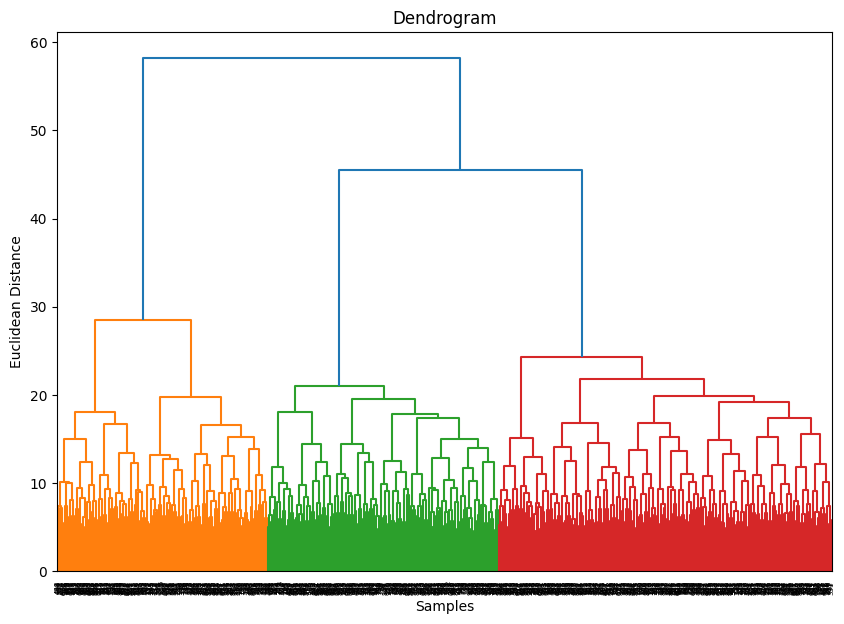

In [25]:
# Visualizing dendrogram to determine the number of clusters
def plot_dendrogram(X):
    Z = linkage(X, method='ward')
    plt.figure(figsize=(10, 7))
    dendrogram(Z)
    plt.title('Dendrogram')
    plt.xlabel('Samples')
    plt.ylabel('Euclidean Distance')
    plt.show()

# Plot the dendrogram
plot_dendrogram(X)

In [26]:
# Define the agglomerative clustering model
def agglomerative_clustering(X, n_clusters, linkage):
    model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
    labels = model.fit_predict(X)
    return labels

# Evaluating the clustering performance using silhouette score
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    score = silhouette_score(X, labels)
    return score

In [35]:
def tune_hyperparameters(X, n_clusters_range):
    best_score = -1
    best_params = {}
    # Parameter grid
    linkage_options = ['ward', 'complete', 'average', 'single']
    
    for n_clusters in n_clusters_range:
        for linkage_method in linkage_options:
            
            labels = agglomerative_clustering(X, n_clusters, linkage_method)
            # Calculate silhouette score if more than 1 cluster is formed
            if len(set(labels)) > 1:
                score = silhouette_score(X, labels)
                print(f"Clusters: {n_clusters}, Linkage: {linkage_method}, Score: {score}")
                if score > best_score:
                    best_score = score
                    best_params = {'n_clusters': n_clusters, 'linkage': linkage_method}
    
    return best_params, best_score

In [44]:
# Tune hyperparameters
best_params, best_score = tune_hyperparameters(X, range(10, 20))

print(f"Best Parameters: {best_params}")
print(f"Best Silhouette Score: {best_score}")

Clusters: 10, Linkage: ward, Score: 0.021936658128016404
Clusters: 10, Linkage: complete, Score: 0.004630152782862795
Clusters: 10, Linkage: average, Score: 0.01146456922568502
Clusters: 10, Linkage: single, Score: -0.08140542082730776
Clusters: 11, Linkage: ward, Score: 0.020240186043038528
Clusters: 11, Linkage: complete, Score: 0.003102354315560969
Clusters: 11, Linkage: average, Score: 0.005774631584539968
Clusters: 11, Linkage: single, Score: -0.08729997572861256
Clusters: 12, Linkage: ward, Score: 0.019909655759437997
Clusters: 12, Linkage: complete, Score: 0.003702075642615589
Clusters: 12, Linkage: average, Score: -5.897015278015383e-05
Clusters: 12, Linkage: single, Score: -0.09212393672822548
Clusters: 13, Linkage: ward, Score: 0.018641964385552233
Clusters: 13, Linkage: complete, Score: 0.0018224983933098676
Clusters: 13, Linkage: average, Score: -0.0013004254555288148
Clusters: 13, Linkage: single, Score: -0.10889670038128688
Clusters: 14, Linkage: ward, Score: 0.0180298033

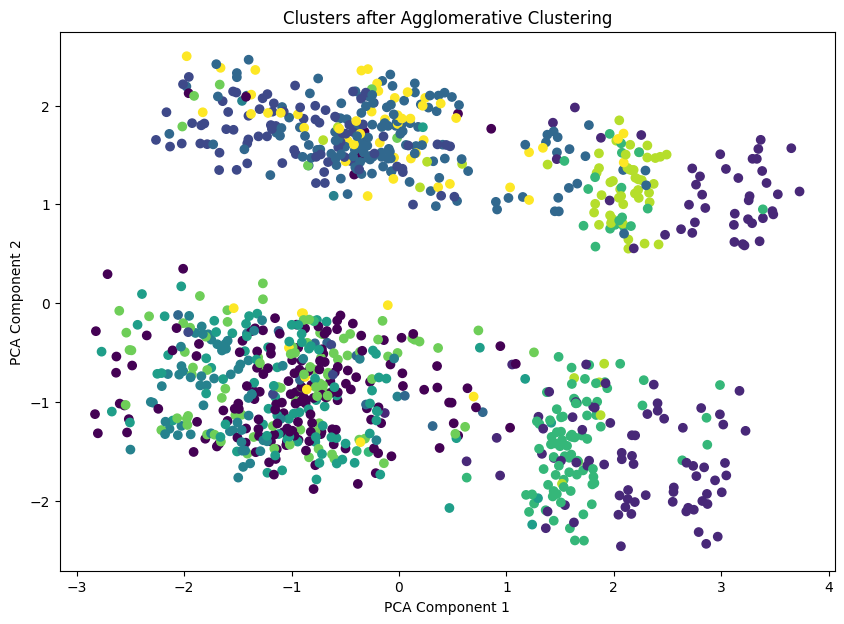

In [45]:
# Applying the best model based on the tuned hyperparameters
final_model = AgglomerativeClustering(n_clusters=best_params['n_clusters'], linkage=best_params['linkage'])
final_labels = final_model.fit_predict(X)

# Visualize the clustering result by reducing using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=final_labels, cmap='viridis')
plt.title('Clusters after Agglomerative Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [49]:
data['Cluster Label'] = final_labels

sorted_agg = data.sort_values(by = 'Cluster Label')
sorted_agg

,UserID,Age,Gender,Location,Income,Debt,Owns Property,Profession,Demographics,Platform,Total Time Spent,Number of Sessions,Video Category,Video Length,Engagement,Importance Score,Time Spent On Video,Number of Videos Watched,Scroll Rate,Frequency,Satisfaction,Watch Reason,DeviceType,OS,Watch Time,Addiction Level,ConnectionType,Cluster Label
706,707,46,Male,Barzil,68933,True,False,Labor/Worker,Rural,YouTube,239,4,Trends,12,6895,1,21,35,39,Evening,5,Habit,Smartphone,Android,4:25 PM,3,Mobile Data,0
173,174,47,Male,India,97067,True,True,Cashier,Rural,Instagram,177,19,Gaming,8,6513,2,22,8,46,Evening,4,Entertainment,Tablet,Android,2:00 PM,2,Mobile Data,0
177,178,56,Female,Indonesia,85794,True,True,Labor/Worker,Rural,YouTube,150,14,Trends,26,9196,6,13,30,75,Evening,4,Boredom,Tablet,MacOS,2:00 PM,2,Mobile Data,0
502,503,54,Male,Pakistan,82068,True,False,Students,Urban,Instagram,247,12,Jokes/Memes,20,6765,2,13,45,72,Evening,3,Entertainment,Tablet,Android,3:55 PM,1,Mobile Data,0
179,180,18,Other,Indonesia,99473,True,True,Waiting staff,Urban,YouTube,271,10,Vlogs,4,972,5,24,36,62,Afternoon,5,Entertainment,Smartphone,iOS,5:00 PM,3,Mobile Data,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
890,891,64,Female,Mexico,43554,False,True,Waiting staff,Rural,TikTok,143,14,Jokes/Memes,15,8566,1,3,4,98,Afternoon,7,Boredom,Tablet,Android,5:00 PM,5,Wi-Fi,9
784,785,31,Male,Japan,42173,False,False,Students,Urban,Facebook,36,2,Jokes/Memes,21,2206,6,25,3,24,Evening,4,Habit,Smartphone,iOS,2:00 PM,2,Wi-Fi,9
931,932,43,Male,India,31950,False,False,Waiting staff,Rural,Facebook,244,1,Gaming,13,1667,6,18,23,74,Afternoon,7,Habit,Smartphone,iOS,5:45 PM,5,Wi-Fi,9
425,426,59,Female,Barzil,36724,False,True,Artist,Urban,TikTok,33,11,Pranks,25,2019,4,26,6,97,Night,7,Boredom,Smartphone,Android,11:30 PM,5,Mobile Data,9


/var/folders/61/dxgzpm2j4tn2wtpf92v4yzdh0000gn/T/ipykernel_97472/4093520768.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Cluster Label', y='Addiction Level', data=cluster_avg, ci=None,
/var/folders/61/dxgzpm2j4tn2wtpf92v4yzdh0000gn/T/ipykernel_97472/4093520768.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster Label', y='Addiction Level', data=cluster_avg, ci=None,
/var/folders/61/dxgzpm2j4tn2wtpf92v4yzdh0000gn/T/ipykernel_97472/4093520768.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


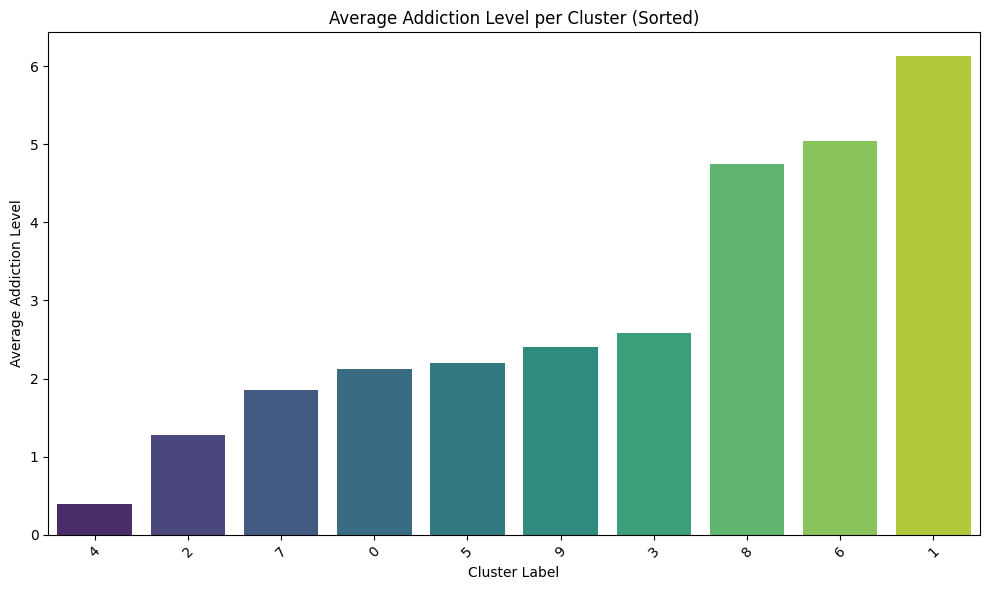

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group by Cluster_Label and calculate the average Addiction Level
cluster_avg = data.groupby('Cluster Label').agg({
    'Addiction Level': 'mean'
}).reset_index()

# Sort by Addiction Level in ascending order
cluster_avg = cluster_avg.sort_values(by='Addiction Level', ascending=True)

# Set up the figure
fig, ax = plt.subplots(figsize=(10, 6))

# Bar plot for Addiction Level using viridis palette, specifying the order explicitly
sns.barplot(x='Cluster Label', y='Addiction Level', data=cluster_avg, ci=None, 
            palette='viridis', ax=ax, order=cluster_avg['Cluster Label'])

# Customize the axis
ax.set_title('Average Addiction Level per Cluster (Sorted)')
ax.set_xlabel('Cluster Label')
ax.set_ylabel('Average Addiction Level', color='black')
ax.tick_params(axis='y', labelcolor='black')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


In [64]:
data[data['Cluster Label'] == 4]

,UserID,Age,Gender,Location,Income,Debt,Owns Property,Profession,Demographics,Platform,Total Time Spent,Number of Sessions,Video Category,Video Length,Engagement,Importance Score,Time Spent On Video,Number of Videos Watched,Scroll Rate,Frequency,Satisfaction,Watch Reason,DeviceType,OS,Watch Time,Addiction Level,ConnectionType,Cluster Label
95,96,24,Other,Pakistan,70669,True,True,Students,Rural,YouTube,27,16,Jokes/Memes,12,6194,9,22,25,33,Morning,2,Habit,Smartphone,Android,8:00 AM,0,Wi-Fi,4
144,145,59,Male,Mexico,61971,True,False,Waiting staff,Rural,Facebook,280,2,Life Hacks,18,5526,5,16,5,99,Morning,2,Entertainment,Smartphone,Android,8:00 AM,0,Mobile Data,4
188,189,26,Female,India,59901,True,True,driver,Rural,Instagram,180,17,Entertainment,1,2407,4,16,47,34,Morning,2,Entertainment,Smartphone,Windows,8:00 AM,0,Wi-Fi,4
198,199,58,Male,United States,62870,True,False,Artist,Rural,YouTube,190,3,Pranks,3,581,9,25,28,42,Morning,2,Boredom,Computer,Android,8:00 AM,0,Wi-Fi,4
217,218,49,Male,United States,69416,True,False,Waiting staff,Urban,YouTube,40,13,Life Hacks,17,1839,9,18,40,42,Morning,2,Procrastination,Smartphone,Android,9:15 AM,0,Mobile Data,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
935,936,54,Male,Vietnam,75243,True,False,Labor/Worker,Urban,Instagram,96,1,Jokes/Memes,18,8204,3,27,8,64,Night,1,Boredom,Tablet,Android,10:15 PM,0,Mobile Data,4
946,947,41,Male,United States,60992,True,True,Cashier,Urban,Facebook,223,12,ASMR,18,3377,3,12,5,65,Night,2,Boredom,Smartphone,MacOS,10:15 PM,0,Mobile Data,4
958,959,45,Other,Vietnam,72870,True,False,Labor/Worker,Rural,YouTube,127,14,Vlogs,12,3444,7,28,48,83,Morning,2,Boredom,Smartphone,Android,9:55 AM,0,Mobile Data,4
970,971,62,Female,Germany,65671,True,True,Students,Rural,TikTok,95,19,Gaming,6,2696,9,1,24,18,Night,1,Entertainment,Smartphone,MacOS,10:15 PM,0,Wi-Fi,4


In [73]:
data[data['Cluster Label'] == 1]

,UserID,Age,Gender,Location,Income,Debt,Owns Property,Profession,Demographics,Platform,Total Time Spent,Number of Sessions,Video Category,Video Length,Engagement,Importance Score,Time Spent On Video,Number of Videos Watched,Scroll Rate,Frequency,Satisfaction,Watch Reason,DeviceType,OS,Watch Time,Addiction Level,ConnectionType,Cluster Label
22,23,19,Female,Indonesia,87155,True,False,Students,Rural,Instagram,242,10,Entertainment,26,6645,4,2,48,40,Night,7,Boredom,Smartphone,Android,9:00 PM,5,Mobile Data,1
43,44,21,Female,Pakistan,61800,True,False,Waiting staff,Rural,Instagram,267,7,Gaming,27,6635,8,28,46,30,Night,7,Entertainment,Tablet,Windows,9:00 PM,5,Mobile Data,1
84,85,64,Male,Barzil,82032,True,False,Labor/Worker,Urban,Instagram,157,7,Jokes/Memes,20,8055,8,1,13,92,Night,7,Boredom,Tablet,iOS,9:00 PM,5,Wi-Fi,1
132,133,31,Female,India,76700,True,True,Waiting staff,Rural,Instagram,83,17,ASMR,27,4129,1,13,29,9,Night,7,Entertainment,Tablet,Android,9:00 PM,5,Mobile Data,1
251,252,57,Female,United States,52602,True,False,driver,Rural,TikTok,132,13,Entertainment,4,2417,9,8,42,76,Night,7,Habit,Smartphone,Android,8:30 PM,5,Mobile Data,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
965,966,19,Male,India,67832,True,True,Students,Rural,YouTube,30,14,Gaming,27,2057,6,1,49,51,Night,7,Entertainment,Smartphone,iOS,10:15 PM,5,Mobile Data,1
966,967,32,Female,India,48151,False,False,driver,Rural,YouTube,180,6,ASMR,5,663,6,12,20,43,Night,7,Habit,Tablet,Android,10:15 PM,5,Mobile Data,1
976,977,36,Male,Pakistan,78585,True,True,Students,Rural,Instagram,269,2,Entertainment,6,5125,4,10,44,24,Evening,7,Habit,Smartphone,iOS,4:25 PM,5,Mobile Data,1
985,986,55,Female,Germany,69429,True,False,Students,Rural,TikTok,104,6,Trends,2,8135,9,10,3,87,Night,7,Boredom,Tablet,Android,10:15 PM,5,Mobile Data,1


In [68]:
import pandas as pd

# Assuming 'data' is already loaded and contains the necessary columns

# Filter the data for Cluster Labels 4 and 1
cluster_4 = data[data['Cluster Label'] == 4]
cluster_1 = data[data['Cluster Label'] == 1]

# Define the columns to compare
columns_to_compare = ['Age', 'Gender', 'Location', 'Income', 'Demographics', 'Addiction Level']


cluster_4_mean = cluster_4[['Age', 'Income', 'Addiction Level']].mean()
cluster_4_mean


Income             74960.787879
Addiction Level        0.393939
dtype: float64

In [70]:
def aggregate_by_most_frequent(df):
    # Apply the mode function to each column and select the first most frequent value
    most_frequent_values = df.mode().iloc[0]
    return most_frequent_values

# Example usage
most_frequent_values = aggregate_by_most_frequent(cluster_4[['Gender', 'Location', 'Demographics']])
print(most_frequent_values)

Gender           Male
Location        India
Demographics    Rural
Name: 0, dtype: object


In [74]:
import pandas as pd

# Function to calculate the weighted frequency of categories
def weighted_mode(df_cluster, df_total, column):
    # Calculate overall frequency of each category in the entire dataset
    total_freq = df_total[column].value_counts(normalize=True)
    
    # Calculate frequency of each category within the cluster
    cluster_freq = df_cluster[column].value_counts(normalize=True)
    
    # Calculate weighted frequencies (cluster frequency / total frequency)
    weighted_freq = (cluster_freq / total_freq).fillna(0)
    
    # Return the category with the highest weighted frequency
    return weighted_freq.idxmax()

# Filter the data for Cluster Labels 4 and 1
cluster_4 = data[data['Cluster Label'] == 4]
cluster_1 = data[data['Cluster Label'] == 1]

# Define the columns to compare
categorical_columns = ['Gender', 'Location', 'Demographics']
numerical_columns = ['Age', 'Income', 'Addiction Level']

# Apply the weighted mode calculation for each categorical column in Cluster 4
cluster_4_weighted_modes = {col: weighted_mode(cluster_4, data, col) for col in categorical_columns}
cluster_4_categorical_mode = pd.Series(cluster_4_weighted_modes)

# Apply the weighted mode calculation for each categorical column in Cluster 1
cluster_1_weighted_modes = {col: weighted_mode(cluster_1, data, col) for col in categorical_columns}
cluster_1_categorical_mode = pd.Series(cluster_1_weighted_modes)

# Calculate the mean for numerical columns for each cluster
cluster_4_numerical_mean = cluster_4[numerical_columns].mean()
cluster_1_numerical_mean = cluster_1[numerical_columns].mean()

# Combine the categorical and numerical aggregated data into DataFrames
cluster_4_aggregated = pd.concat([cluster_4_categorical_mode, cluster_4_numerical_mean], axis=0).to_frame(name='Cluster 4')
cluster_1_aggregated = pd.concat([cluster_1_categorical_mode, cluster_1_numerical_mean], axis=0).to_frame(name='Cluster 1')

# Combine both clusters into one DataFrame
combined_aggregated = pd.concat([cluster_4_aggregated, cluster_1_aggregated], axis=1)

# Display the combined DataFrame
print(combined_aggregated)


                    Cluster 4     Cluster 1
Gender                 Female        Female
Location                Japan        Barzil
Demographics            Rural         Urban
Age                 41.681818     42.652174
Income           74960.787879  62510.252174
Addiction Level      0.393939      6.130435


### Part 3: LSH Minhasing for Identificaiton of Frequent User Similarity Features

In [80]:
import pandas as pd
from datasketch import MinHash, MinHashLSH

# Assuming 'data' is already loaded and contains the necessary columns

# Select the relevant columns based on correlation with Addiction Level
features_to_use = ['Frequency', 'Watch Reason', 'DeviceType', 'Age', 'Addiction Level']

# Convert the categorical features into strings and combine all relevant features for each user
data['User_Features'] = data[features_to_use].astype(str).agg(' '.join, axis=1)

# Function to create MinHash and LSH setup
def minhash_lsh(data, threshold=0.5, num_perm=128):
    lsh = MinHashLSH(threshold=threshold, num_perm=num_perm)
    minhash_objects = []
    
    for idx, features in enumerate(data['User_Features']):
        m = MinHash(num_perm=num_perm)
        for token in features.split():
            m.update(token.encode('utf8'))
        minhash_objects.append(m)
        lsh.insert(f"user_{idx}", m)
    
    return lsh, minhash_objects

# Apply MinHash LSH on the dataset
lsh, minhash_objects = minhash_lsh(data)

# Function to find similar users based on a given user's index
def find_similar_users(lsh, user_idx, minhash_objects):
    user_key = f"user_{user_idx}"
    return lsh.query(minhash_objects[user_idx])

# Example: Find similar users to the first user in the dataset
similar_users = find_similar_users(lsh, 0, minhash_objects)

# Extract the original user features and their addiction levels for comparison
similar_user_data = data.iloc[[int(user.split('_')[1]) for user in similar_users]]

# Display similar user data
print("Similar Users based on Features Correlated with Addiction Level:")
display(similar_user_data[features_to_use])


Similar Users based on Features Correlated with Addiction Level:


,Frequency,Watch Reason,DeviceType,Age,Addiction Level
98,Night,Entertainment,Smartphone,18,5
931,Afternoon,Habit,Smartphone,43,5
389,Night,Procrastination,Tablet,63,5
136,Night,Boredom,Smartphone,43,5
565,Night,Habit,Smartphone,29,5
...,...,...,...,...,...
291,Night,Entertainment,Smartphone,35,5
368,Night,Habit,Smartphone,19,5
802,Night,Entertainment,Smartphone,59,5
560,Night,Habit,Smartphone,42,5


In [85]:
data

,UserID,Age,Gender,Location,Income,Debt,Owns Property,Profession,Demographics,Platform,Total Time Spent,Number of Sessions,Video Category,Video Length,Engagement,Importance Score,Time Spent On Video,Number of Videos Watched,Scroll Rate,Frequency,Satisfaction,Watch Reason,DeviceType,OS,Watch Time,Addiction Level,ConnectionType,Cluster Label,User_Features
0,1,56,Male,Pakistan,82812,True,True,Engineer,Rural,Instagram,80,17,Pranks,24,7867,5,26,22,87,Night,7,Procrastination,Smartphone,Android,9:00 PM,5,Mobile Data,6,Night Procrastination Smartphone 56 7
1,2,46,Female,Mexico,27999,False,True,Artist,Urban,Instagram,228,14,Pranks,19,5944,6,25,31,46,Afternoon,5,Habit,Computer,Android,5:00 PM,3,Wi-Fi,3,Afternoon Habit Computer 46 5
2,3,32,Female,United States,42436,False,True,Engineer,Rural,Facebook,30,6,Vlogs,19,8674,3,9,7,88,Evening,4,Entertainment,Tablet,Android,2:00 PM,2,Mobile Data,3,Evening Entertainment Tablet 32 4
3,4,60,Male,Barzil,62963,True,False,Waiting staff,Rural,YouTube,101,19,Vlogs,4,2477,2,6,41,93,Night,7,Habit,Smartphone,Android,9:00 PM,5,Mobile Data,6,Night Habit Smartphone 60 7
4,5,25,Male,Pakistan,22096,False,True,Manager,Urban,TikTok,136,6,Gaming,19,3093,7,13,21,4,Morning,2,Boredom,Smartphone,iOS,8:00 AM,0,Mobile Data,2,Morning Boredom Smartphone 25 2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,22,Male,India,74254,True,True,Students,Rural,TikTok,144,7,Gaming,1,5179,6,17,17,47,Afternoon,1,Procrastination,Smartphone,iOS,5:45 PM,0,Mobile Data,5,Afternoon Procrastination Smartphone 22 1
996,997,40,Female,Pakistan,27006,False,False,Waiting staff,Urban,Facebook,231,15,Life Hacks,2,1803,4,2,17,15,Night,2,Boredom,Smartphone,MacOS,10:15 PM,0,Mobile Data,2,Night Boredom Smartphone 40 2
997,998,27,Male,India,94218,True,True,Waiting staff,Rural,TikTok,165,1,Pranks,12,9290,3,9,28,44,Night,1,Procrastination,Smartphone,iOS,10:15 PM,0,Mobile Data,5,Night Procrastination Smartphone 27 1
998,999,61,Male,Pakistan,85344,True,False,Students,Urban,YouTube,151,11,Life Hacks,15,2050,5,12,30,62,Night,7,Procrastination,Smartphone,MacOS,10:15 PM,5,Wi-Fi,1,Night Procrastination Smartphone 61 7


In [86]:
import pandas as pd
import numpy as np
from datasketch import MinHash, MinHashLSH

# Function to create MinHash and LSH setup
def minhash_lsh(data, features, threshold=0.5, num_perm=128):
    """
    Creates LSH and MinHash objects for the given data.
    :param data: DataFrame containing user features.
    :param features: List of features to use for similarity calculation (excluding 'Addiction Level').
    :param threshold: Jaccard similarity threshold for LSH.
    :param num_perm: Number of permutations for MinHash.
    :return: LSH object and list of MinHash objects for each user.
    """
    # Create a combined feature set for each user, excluding Addiction Level
    data['User_Features'] = data[features].astype(str).agg(' '.join, axis=1)
    
    lsh = MinHashLSH(threshold=threshold, num_perm=num_perm)
    minhash_objects = []
    
    for idx, features_str in enumerate(data['User_Features']):
        m = MinHash(num_perm=num_perm)
        for token in features_str.split():
            m.update(token.encode('utf8'))
        minhash_objects.append(m)
        lsh.insert(f"user_{idx}", m)
    
    return lsh, minhash_objects

# Function to find similar users based on a given user's index
def find_similar_users(lsh, user_idx, minhash_objects):
    """
    Find similar users based on LSH query.
    :param lsh: LSH object.
    :param user_idx: Index of the user to find similar users for.
    :param minhash_objects: List of MinHash objects.
    :return: List of indices of similar users.
    """
    similar_users = lsh.query(minhash_objects[user_idx])
    # Extract the integer index from the 'user_x' format
    return [int(user.split('_')[1]) for user in similar_users]

# Function to identify and analyze profiles of users who might be at risk of addiction
def identify_at_risk_profiles(data, features, addiction_column='Addiction Level', num_users=5, threshold=0.5):
    """
    Identifies similar user profiles for randomly selected users with different addiction levels.
    :param data: DataFrame containing user data.
    :param features: List of features to use for similarity calculation.
    :param addiction_column: Column name representing addiction levels.
    :param num_users: Number of users (one per addiction level) to randomly select and analyze.
    :param threshold: Jaccard similarity threshold for LSH.
    :return: Dictionary with user profiles and their similar user groups.
    """
    # Remove the addiction level column from features for LSH
    lsh_features = [feature for feature in features if feature != addiction_column]

    # Create LSH and MinHash objects
    lsh, minhash_objects = minhash_lsh(data, lsh_features, threshold)

    # Sample users with different addiction levels
    sampled_users = data.groupby(addiction_column).apply(lambda x: x.sample(1)).reset_index(drop=True)
    
    profiles = {}
    
    for idx, user in sampled_users.iterrows():
        user_idx = user.name  # Get the index of the sampled user in the dataset
        similar_user_indices = find_similar_users(lsh, user_idx, minhash_objects)
        
        # Extract similar users based on LSH results
        similar_user_data = data.iloc[similar_user_indices]
        
        # Store the profile information
        profiles[f"User with {addiction_column} {user[addiction_column]}"] = {
            'User Profile': user[features],
            'Similar Users': similar_user_data[features + [addiction_column]]
        }
    
    return profiles

# Usage example
# Define the features to use (excluding Addiction Level)
features_to_use = ['Frequency', 'Watch Reason', 'DeviceType', 'Age', 'Satisfaction']

# Call the function to identify profiles of at-risk users
profiles = identify_at_risk_profiles(data, features_to_use, num_users=5, threshold=0.7)

# Display the profiles and similar users
for profile_key, profile_data in profiles.items():
    print(f"\n{profile_key}:")
    print("User Profile:")
    display(profile_data['User Profile'].to_frame().T)
    print("\nSimilar Users:")
    display(profile_data['Similar Users'])



User with Addiction Level 0:
User Profile:


/var/folders/61/dxgzpm2j4tn2wtpf92v4yzdh0000gn/T/ipykernel_97472/800401721.py:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_users = data.groupby(addiction_column).apply(lambda x: x.sample(1)).reset_index(drop=True)


,Frequency,Watch Reason,DeviceType,Age,Satisfaction
0,Night,Procrastination,Computer,27,2



Similar Users:


,Frequency,Watch Reason,DeviceType,Age,Satisfaction,Addiction Level
0,Night,Procrastination,Smartphone,56,7,5
184,Night,Entertainment,Smartphone,56,7,5
110,Night,Entertainment,Smartphone,56,7,5
885,Afternoon,Procrastination,Smartphone,20,7,5



User with Addiction Level 1:
User Profile:


,Frequency,Watch Reason,DeviceType,Age,Satisfaction
1,Morning,Procrastination,Tablet,47,3



Similar Users:


,Frequency,Watch Reason,DeviceType,Age,Satisfaction,Addiction Level
284,Afternoon,Habit,Computer,57,5,3
295,Afternoon,Habit,Computer,52,5,3
308,Afternoon,Habit,Computer,34,5,3
1,Afternoon,Habit,Computer,46,5,3



User with Addiction Level 2:
User Profile:


,Frequency,Watch Reason,DeviceType,Age,Satisfaction
2,Evening,Habit,Computer,42,4



Similar Users:


,Frequency,Watch Reason,DeviceType,Age,Satisfaction,Addiction Level
834,Evening,Entertainment,Tablet,20,4,2
2,Evening,Entertainment,Tablet,32,4,2
13,Evening,Entertainment,Tablet,57,4,2
241,Evening,Entertainment,Tablet,20,4,2



User with Addiction Level 3:
User Profile:


,Frequency,Watch Reason,DeviceType,Age,Satisfaction
3,Evening,Procrastination,Tablet,28,5



Similar Users:


,Frequency,Watch Reason,DeviceType,Age,Satisfaction,Addiction Level
121,Night,Habit,Tablet,54,7,5
835,Night,Habit,Smartphone,44,7,5
268,Night,Habit,Smartphone,54,7,5
377,Night,Habit,Tablet,59,7,5
854,Night,Habit,Smartphone,31,7,5
906,Night,Habit,Smartphone,42,7,5
386,Night,Habit,Smartphone,37,7,5
68,Night,Habit,Smartphone,43,7,5
374,Night,Boredom,Smartphone,60,7,5
38,Night,Habit,Smartphone,24,7,5



User with Addiction Level 4:
User Profile:


,Frequency,Watch Reason,DeviceType,Age,Satisfaction
4,Afternoon,Boredom,Smartphone,39,6



Similar Users:


,Frequency,Watch Reason,DeviceType,Age,Satisfaction,Addiction Level
958,Morning,Boredom,Smartphone,45,2,0
968,Morning,Boredom,Smartphone,25,2,2
886,Morning,Boredom,Smartphone,64,2,0
280,Morning,Boredom,Smartphone,28,2,0
4,Morning,Boredom,Smartphone,25,2,0
348,Morning,Boredom,Smartphone,38,2,0



User with Addiction Level 5:
User Profile:


,Frequency,Watch Reason,DeviceType,Age,Satisfaction
5,Afternoon,Habit,Tablet,22,7



Similar Users:


,Frequency,Watch Reason,DeviceType,Age,Satisfaction,Addiction Level
315,Night,Entertainment,Computer,55,7,5
8,Night,Entertainment,Computer,40,7,5
229,Night,Entertainment,Computer,28,7,5
87,Night,Entertainment,Computer,42,7,5
5,Night,Entertainment,Computer,38,7,5



User with Addiction Level 6:
User Profile:


,Frequency,Watch Reason,DeviceType,Age,Satisfaction
6,Night,Entertainment,Smartphone,38,8



Similar Users:


,Frequency,Watch Reason,DeviceType,Age,Satisfaction,Addiction Level
378,Morning,Habit,Smartphone,43,2,0
357,Morning,Habit,Smartphone,20,2,0
768,Afternoon,Habit,Smartphone,56,2,0
6,Morning,Habit,Smartphone,56,2,0



User with Addiction Level 7:
User Profile:


,Frequency,Watch Reason,DeviceType,Age,Satisfaction
7,Night,Habit,Tablet,28,9



Similar Users:


,Frequency,Watch Reason,DeviceType,Age,Satisfaction,Addiction Level
132,Night,Entertainment,Tablet,31,7,5
7,Night,Entertainment,Tablet,36,7,5
137,Night,Entertainment,Tablet,31,7,5
